In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
gc = gspread.authorize(GoogleCredentials.get_application_default())

INFO:oauth2client.client:Refreshing access_token


In [ ]:
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1647CsDr9YeQGXgWF4WZfJDQSLHpExiUBRnRk6vix2r8/edit?usp=sharing')

In [ ]:
sheet = wb.worksheet('co2_data')
data = sheet.get_all_values()
df = pd.DataFrame(data)

In [ ]:
df.rename(columns={0: "date", 1: "ppm"}, inplace = True)
df['date'] = df['date'].astype('datetime64[ns]')
df['ppm'] = df['ppm'].astype('float')
df['days_since'] = df['date'] - df['date'][0]
df['days_since'] = pd.to_timedelta(df.days_since, errors='coerce').dt.days

Text(0.5, 0, 'Date')

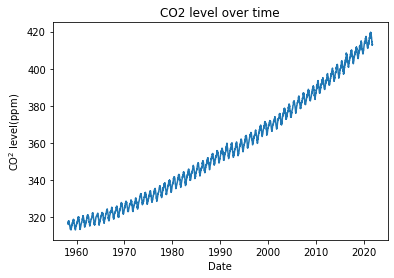

In [ ]:
plt.plot(df['date'], df['ppm'])
plt.title('CO2 level over time')
plt.ylabel('CO$^2$ level(ppm)')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

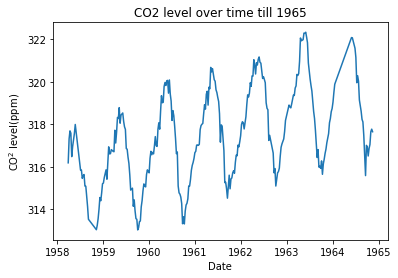

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df['date'][:300], df['ppm'][:300])
plt.title('CO2 level over time till 1965')
plt.ylabel('CO$^2$ level(ppm)')
plt.xlabel('Date')

In [ ]:
T = len(df)
t = df['days_since'] 
y = df['ppm']
n_future = 14600

stan_data = {
    'T' : T,
    't': t,
    'y': y,
    'n_future': n_future,
}


In [ ]:
model = '''
data {
    int<lower=1> T;
    vector[T] t; //time 
    vector[T] y; //temperature 
    int<lower=0> n_future; //number of days to predict in the future 
}
parameters {
    real<lower=0> c0; //intercept 
    real<lower=0> c1; //coef for linear term 
    real<lower=0> c2; //amplitude 
    real<lower=0, upper=1> c3; //constant within the periodic term 
    real<lower=0> c4; //coef for quadratic term 
    real<lower=0> sigma;

}
model {
    //priors
    c0 ~ cauchy(300, 30);
    c1 ~ cauchy(0, 5);
    c2 ~ cauchy(1, 5);
    c3 ~ cauchy(0, 5);
    sigma ~ gamma(1, 0.3);

    //likelihood
    for (i in 1:T) {
        y[i] ~normal(c0 + c1 * t[i] + c4 * t[i]^2 + c2 * cos(2*t[i]*pi()/ 365.25+ c3), sigma);
    }
}
generated quantities{
    //past 
    vector[T] past;
    vector[n_future] future;
    for (i in 1:T) {
        past[i] = normal_rng(c0 + c1 * t[i] + c4 * t[i]^2 + c2 * cos(2*t[i]*pi()/365.25+ c3), sigma);
    }
    //future 
    for (j in 1:n_future) {
        future[j] = normal_rng(c0 + c1 * (t[T]+j) + c4 * (t[T]+j)^2 + c2 * cos(2*(t[T]+j)*pi()/365.25+ c3), sigma);
    }    
}
'''

In [ ]:
stan_model = pystan.StanModel(model_code= model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7c7f5d7852fb75e965a5a24c41ec8e38 NOW.


In [ ]:
results = stan_model.sampling(data=stan_data)
samples = results.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [ ]:
parameters = ['c0', 'c1', 'c2', 'c3', 'c4','sigma']
print(results.stansummary(pars=parameters)) 

Inference for Stan model: anon_model_7c7f5d7852fb75e965a5a24c41ec8e38.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean      sd   2.5%     25%    50%    75%  97.5%  n_eff   Rhat
c0    314.75  1.6e-3    0.07 314.62  314.71 314.75  314.8 314.89   2040    1.0
c1    2.0e-3  3.5e-7  1.4e-5 2.0e-3  2.0e-3 2.0e-3 2.1e-3 2.1e-3   1675    1.0
c2      2.63  6.1e-4    0.03   2.57    2.61   2.63   2.65   2.69   2721    1.0
c3    3.3e-4  6.0e-6  3.4e-4 6.2e-6  9.4e-5 2.3e-4 4.6e-4 1.3e-3   3205    1.0
c4    1.0e-7 1.4e-11 5.9e-10 9.9e-8 10.0e-8 1.0e-7 1.0e-7 1.0e-7   1658    1.0
sigma   1.28  3.2e-4    0.02   1.25    1.27   1.28   1.29   1.31   2503    1.0

Samples were drawn using NUTS at Tue Dec 14 15:54:13 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [ ]:
from datetime import date, timedelta
import datetime
sdate = date(2021,9,25)   #end date of the backcasting 
edate = sdate + datetime.timedelta(days=n_future)   # end date of the forcasting 
# date = pd.date_range(mdate,edate-timedelta(days=1),freq='d')
date = pd.date_range(start= sdate, end= edate, closed='left')

In [ ]:
#sample prediction values
backcasting = samples['past']
forcasting = samples['future']

#Compute 95% interval of the predicted values
forcasting_interval = np.percentile(forcasting, axis=0, q=[2.5, 97.5])
backcasting_interval = np.percentile(backcasting, axis=0, q=[2.5, 97.5])

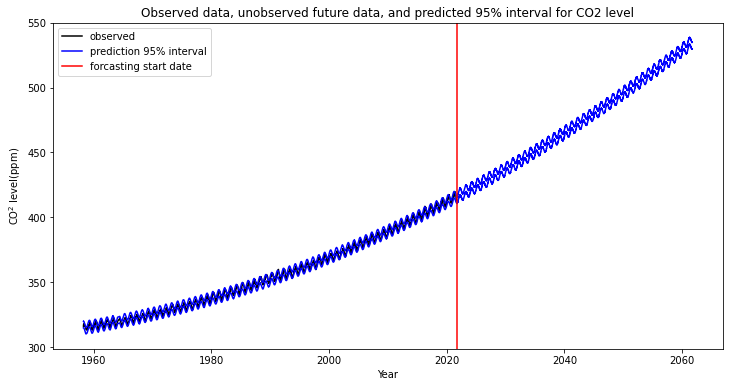

In [ ]:
#Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['ppm'], 'k-', label='observed')
plt.plot(
    df['date'],
    backcasting_interval[0,:], 'b-', label='prediction 95% interval')
plt.plot(
    df['date'],
    backcasting_interval[1,:], 'b-')

plt.plot(
    date,
    forcasting_interval[0,:], 'b-')
plt.plot(
    date,
    forcasting_interval[1,:], 'b-')

plt.axvline(sdate, color='red', label = 'forcasting start date')
plt.xlabel('Year')
plt.ylabel('CO$^2$ level(ppm)')
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval for CO2 level')
plt.show()

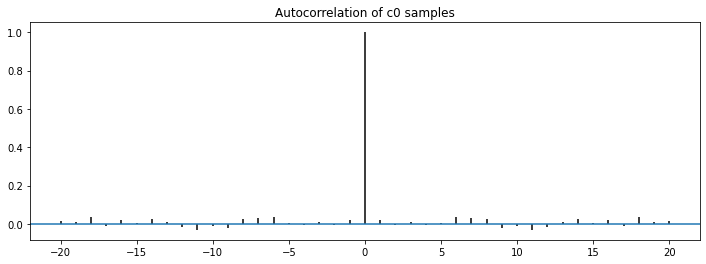

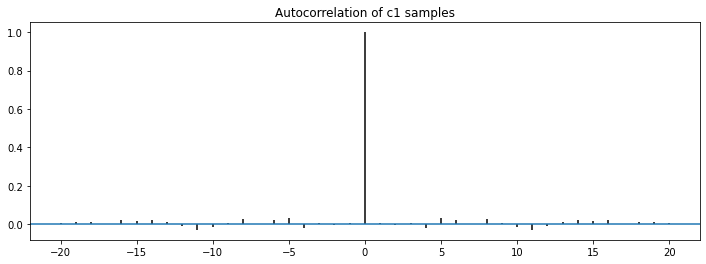

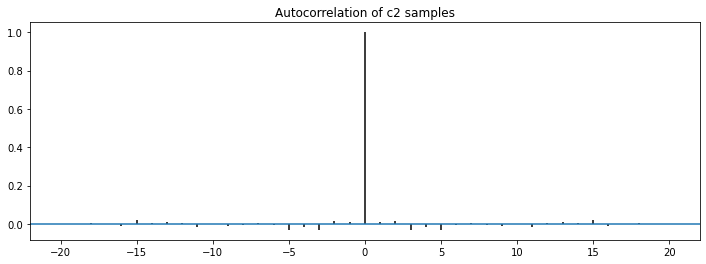

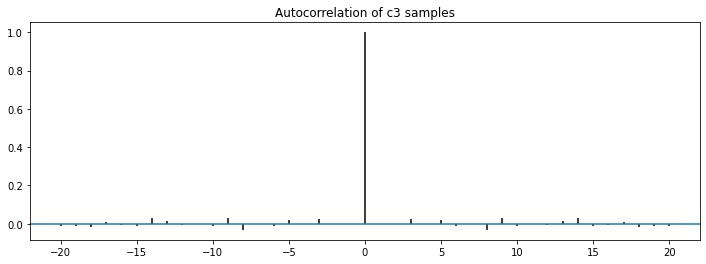

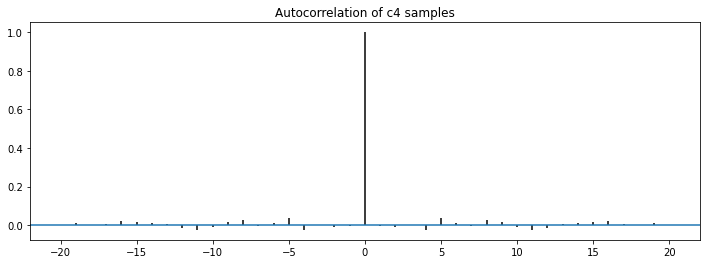

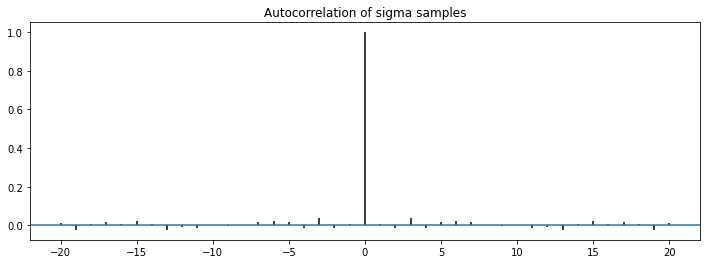

In [ ]:
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
INFO:numexpr.utils:NumExpr defaulting to 2 threads.


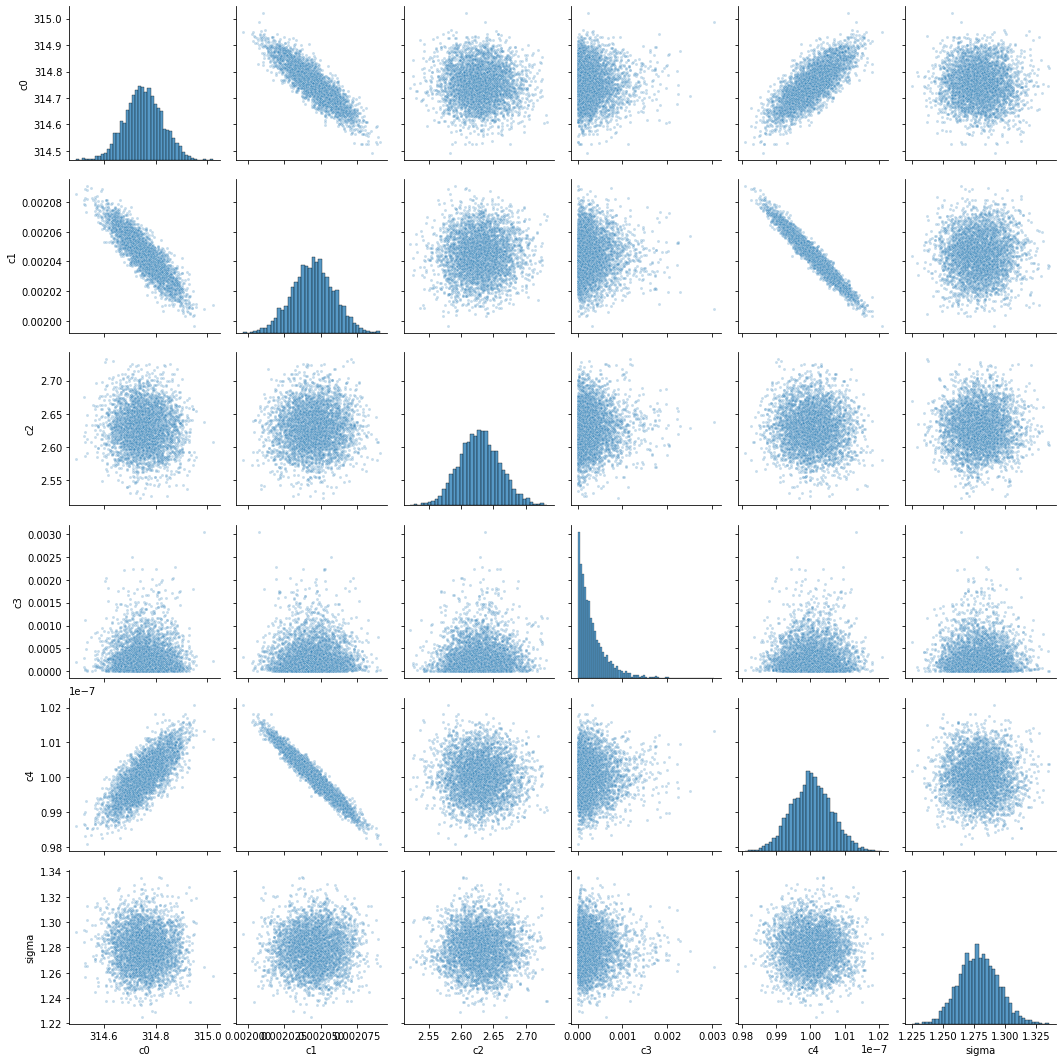

In [ ]:
import seaborn
df = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()